# Selecting the best features of our dataset

In [85]:
#Importing our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#importing our logistic regression model
from sklearn.linear_model import LogisticRegression

#importing ou feature selection model
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split

from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 7
#erasing all spines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False




In [86]:
# Loading our data
data_base = pd.read_pickle('data_base.pkl')
info_cols = ['date',
 'home_team',
 'away_team',
 'season',
 'home_win' ]
# Splitting the data into train and test
X = data_base.loc[:, ~data_base.columns.isin(info_cols)] # excluding info_cols
y = data_base['home_win']

print(f'Feature set shape: {X.shape}, target series shape: {y.shape}')

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# scaling the data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Feature set shape: (2027, 264), target series shape: (2027,)


In [87]:
#Importing our pickled models
lr = pd.read_pickle('models/LogisticRegression.pkl')
svm = pd.read_pickle('models/LinearSVC.pkl')
rf = pd.read_pickle('models/RandomForestClassifier.pkl')
gbc = pd.read_pickle('models/GradientBoostingClassifier.pkl')


### With our trained models on the base dataset, we will now see waht features the models has considered to be more important.

In [88]:
def get_feature_importance(model_importance, cols, n_best_features=10):
    """ Info:
     This function takes a model and returns a dataframe with the feature importance, and plots the top n_best_features.
      -----------------------------------------------------------------------------------------------------------------
       Input:
        model_importance: The attribute of the chosen model that contains the feature importance.
         cols: The columns of the feature set.
          n_best_features: The number of best features to plot and return.
        -----------------------------------------------------------------------------------------------------------------
            Output:
                importances: A dataframe with the feature importance.
                plot: A plot with the top n_best_features.
            """
    importances = (abs(model_importance), cols) # getting the absolute value of the importance
    importances = pd.DataFrame(importances).T
    importances.columns = ['importance', 'feature']
    importances.set_index('feature', inplace=True)
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.head(n_best_features)[::-1].plot(kind='barh', figsize=(10, 4))
    plt.title('Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

    return importances.head(n_best_features)

    

### Logistic Regression

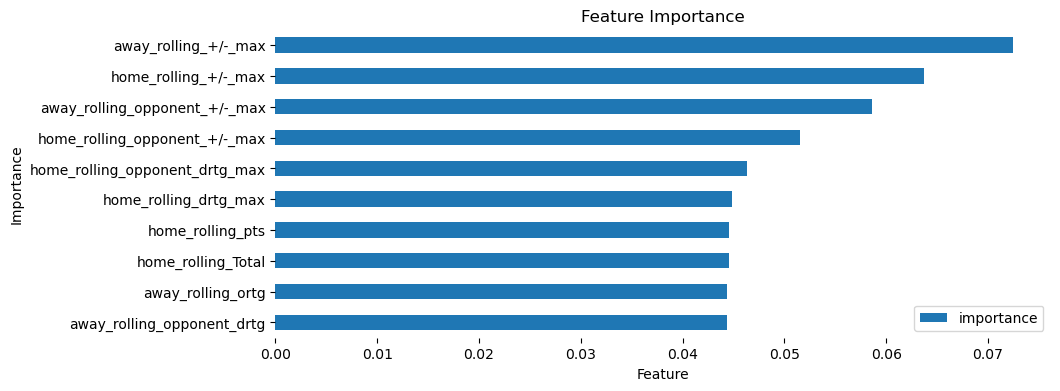

In [89]:
lr_best_features =  get_feature_importance(lr[-1].coef_[0], X.columns, n_best_features=10)


### support vector machine

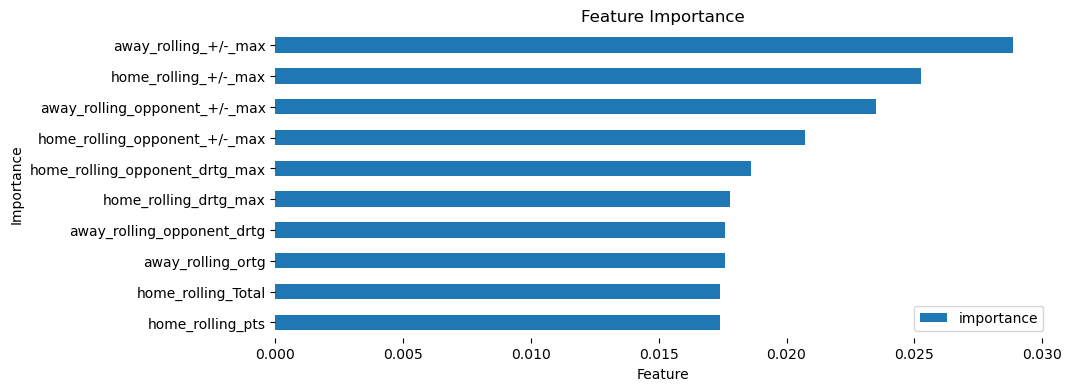

In [90]:
svm_best_features =  get_feature_importance(svm[-1].coef_[0], X.columns, n_best_features=10)

### random forest

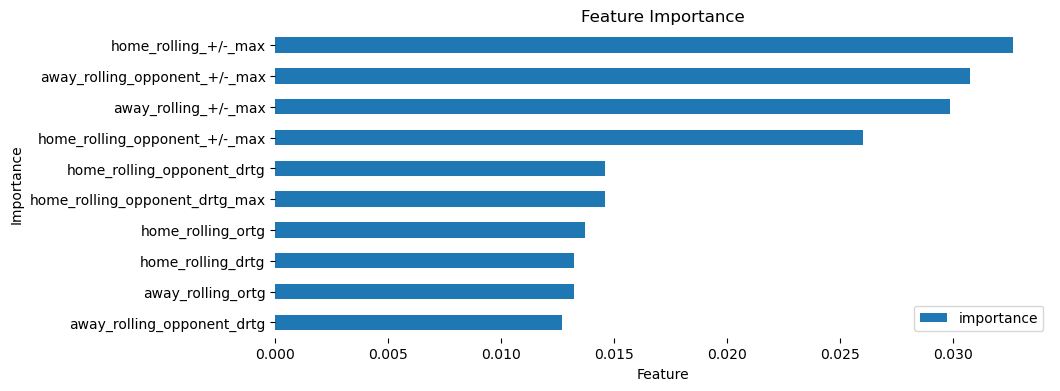

In [91]:
rf_best_features =  get_feature_importance(rf[-1].feature_importances_, X.columns, n_best_features=10)

### Gradient Boosting

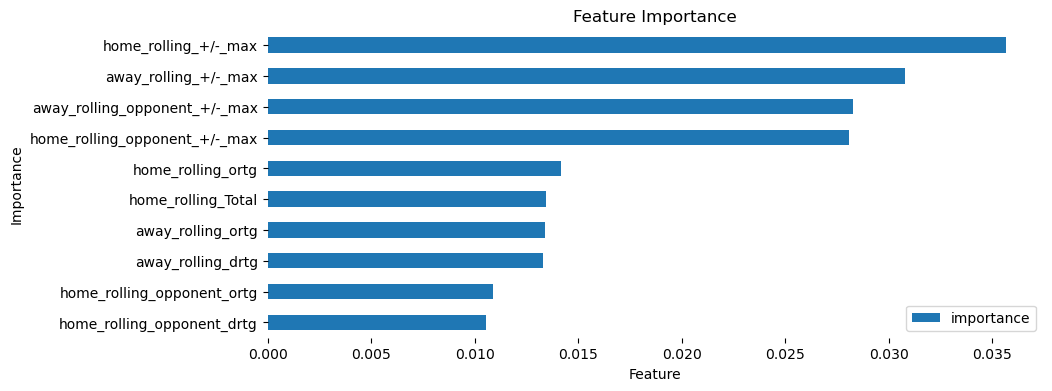

In [92]:
gb_best_features =  get_feature_importance(gbc[-1].feature_importances_, X.columns, n_best_features=10)

### Estimating the n principal components that explain the most part of the model variance

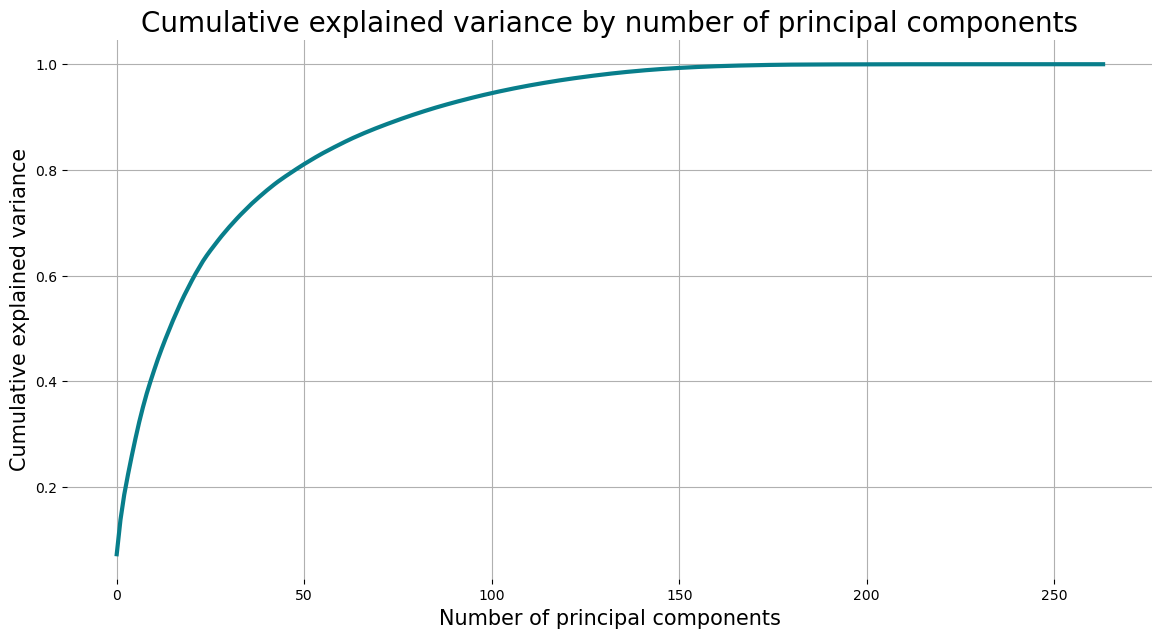

In [94]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B') # type: ignore // cumulative explained variance
plt.xlabel('Number of principal components', size=15)
plt.ylabel('Cumulative explained variance', size=15)
plt.grid(True)
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

We can now associate the principal components to our features to see how relevant they are for the PCA, meaning that the more correlated, the more that feature explain the results. As the first principal component is the most relavant, lets just consider the first col

home_rolling_+/-_max              0.785024
home_rolling_opponent_+/-_max     0.763512
home_rolling_ortg                 0.707245
home_rolling_opponent_drtg        0.707245
home_rolling_opponent_drtg_max    0.697450
home_rolling_ts%                  0.672176
home_rolling_efg%                 0.661675
home_rolling_Total                0.609971
home_rolling_pts                  0.609971
home_rolling_trb%                 0.607265
Name: PC1, dtype: float64

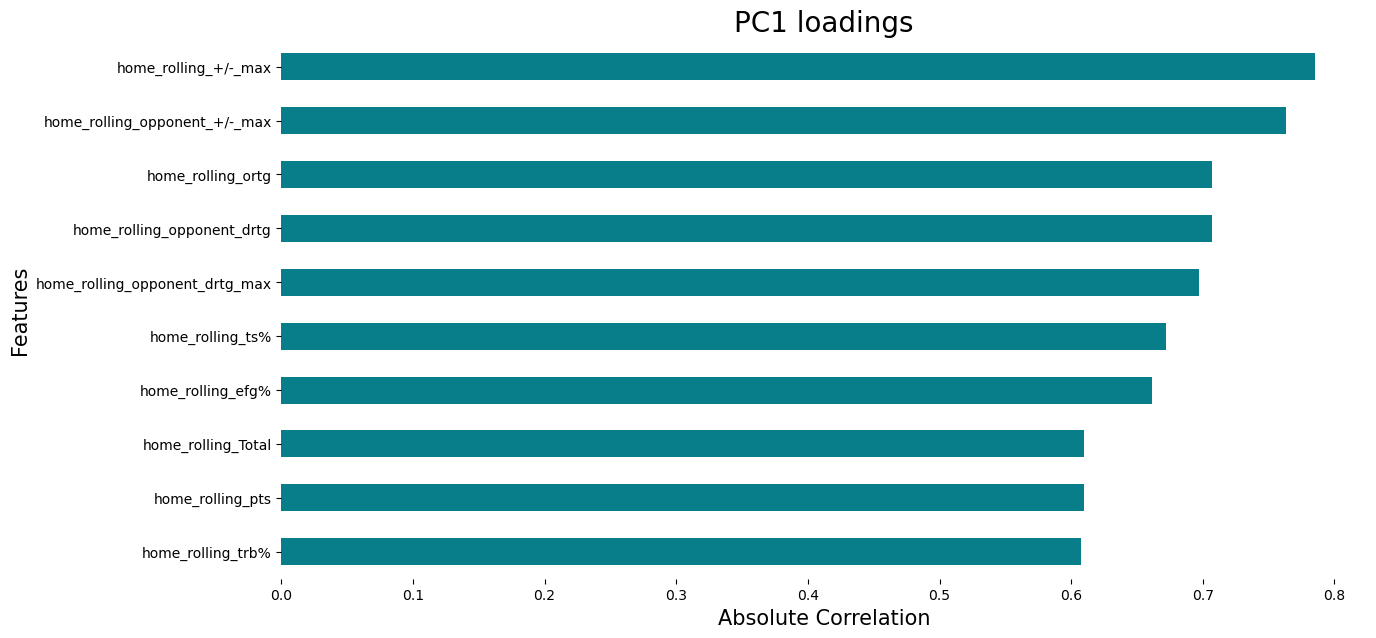

In [114]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), #type: ignore
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)], #type: ignore
    index=X_train.columns #type: ignore
)
loadings['PC1'] = abs(loadings['PC1'])
pca_best_features = loadings['PC1'].sort_values(ascending=False).head(10)

pca_best_features[::-1].plot(kind='barh', color='#087E8B')
plt.title('PC1 loadings', size=20)
plt.ylabel('Features', size=15)
plt.xlabel('Absolute Correlation', size=15)
pca_best_features.head(10)

Comparing the best features for each

In [113]:
df_best_features = pd.DataFrame([lr_best_features.index, svm_best_features.index, rf_best_features.index, gb_best_features.index, pca_best_features.index]).T
df_best_features.columns = ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting', 'PCA']
df_best_features

,Logistic Regression,SVM,Random Forest,Gradient Boosting,PCA
0,away_rolling_+/-_max,away_rolling_+/-_max,home_rolling_+/-_max,home_rolling_+/-_max,home_rolling_+/-_max
1,home_rolling_+/-_max,home_rolling_+/-_max,away_rolling_opponent_+/-_max,away_rolling_+/-_max,home_rolling_opponent_+/-_max
2,away_rolling_opponent_+/-_max,away_rolling_opponent_+/-_max,away_rolling_+/-_max,away_rolling_opponent_+/-_max,home_rolling_ortg
3,home_rolling_opponent_+/-_max,home_rolling_opponent_+/-_max,home_rolling_opponent_+/-_max,home_rolling_opponent_+/-_max,home_rolling_opponent_drtg
4,home_rolling_opponent_drtg_max,home_rolling_opponent_drtg_max,home_rolling_opponent_drtg,home_rolling_ortg,home_rolling_opponent_drtg_max
5,home_rolling_drtg_max,home_rolling_drtg_max,home_rolling_opponent_drtg_max,home_rolling_Total,home_rolling_ts%
6,home_rolling_pts,away_rolling_opponent_drtg,home_rolling_ortg,away_rolling_ortg,home_rolling_efg%
7,home_rolling_Total,away_rolling_ortg,home_rolling_drtg,away_rolling_drtg,home_rolling_Total
8,away_rolling_ortg,home_rolling_Total,away_rolling_ortg,home_rolling_opponent_ortg,home_rolling_pts
9,away_rolling_opponent_drtg,home_rolling_pts,away_rolling_opponent_drtg,home_rolling_opponent_drtg,home_rolling_trb%


Nice insight! We can see that the combination of the players impact are what impacts the most on our predictive models. Now, lets see if that will be the case again after performing feature selection using the exaustive away from sklearn. As an alternative, you could just use like the 30 best features for each model. 

## Note:

* Sklearn says that:

"To finish with, we should note that SelectFromModel is significantly faster than SFS. Indeed, SelectFromModel only needs to fit a model once, while SFS needs to cross-validate many different models for each of the iterations. SFS however works with any model, while SelectFromModel requires the underlying estimator to expose a coef_ attribute or a feature_importances_ attribute." The forward SFS is faster than the backward SFS because it only needs to perform n_features_to_select = 2 iterations, while the backward SFS needs to perform n_features - n_features_to_select = 8 iterations."

* However:

As the faster selection sees only the feature importances, it is like if we did what we just did and select the top features. But in our case, could be that some features perform better in conjunction with other features that are not that important. As we cant say otherwise for now, we are going to take the safe route and do the exaustive selection.

# Performing exaustive feature selection

We are going to specify that, the selector will choose only n features, starting with 100.

In [118]:
#importing the sequential feature selector

from sklearn.feature_selection import SequentialFeatureSelector
from time import time

start = time()
sfs = SequentialFeatureSelector(lr, n_features_to_select=100, direction='backward', scoring='accuracy', cv=5)
sfs.fit(X_train, y_train)
end = time()

print(f"Features selected by forward sequential selection: {X.columns[sfs.get_support()]}") #feature names for the best features
print(f'Time elapsed: {end - start}')




In [ ]:
def select_nBest_features(model, n_features):
    start = time()
    sfs = SequentialFeatureSelector(model, n_features_to_select=n_features, direction='backward', scoring='accuracy', cv=5)
    sfs.fit(X_train, y_train)
    end = time()

    print(f"Features selected by forward sequential selection: {X.columns[sfs.get_support()]}") #feature names for the best features
    print(f'Time elapsed: {end - start}')